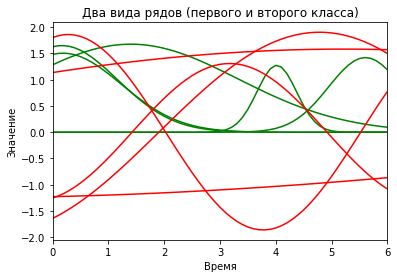

data.shape = (12200, 4)
data.id.nunique() = 200


,t,y,label,id
0,0.0,1.957849,1,0
1,0.1,1.957849,1,0
2,0.2,1.957849,1,0


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters, EfficientFCParameters, MinimalFCParameters

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from math import isnan

N = 100 ## количество семплов каждого класса
Nvis = 5 ## сколько семплов будем визуализировать
timePoints = 61  ## количество элементов в каждом из рядов

df = pd.DataFrame()
data = pd.DataFrame()
t = np.linspace(0, 6, timePoints) 

random.seed(42)

## генерируем семплы первого класса
for i in range(N):
    t0 = 2*np.pi*random.random()
    a1 = 5*random.random()
    A = 1 + random.random()        
    
    df['t']  = t                   ## ось времени
    df['y']  = A*np.exp(-(df.t-t0)**2/2/a1)  ## значения временного ряда
    df['label'] = 1                ## класс временного ряда 
    df['id'] = i                   ## номер временного ряда
    
    data = data.append(df)         ## добавляем семпл в общий дейтафрейм
    if i < Nvis:                   ## визуализируем первые Nvis-штук
        plt.plot(df.t, df.y, color='g') 
    
## генерируем семплы второго класса    
for i in range(N, 2*N):
    A = 1 + random.random()          ## амплитуда
    w = 0 + random.random()          ## частота
    ph = 2*np.pi * random.random()   ## фаза
    
    df['t']  = t                     ## ось времени
    df['y']  = A*np.sin(t*w + ph)    ## значения временного ряда
    df['label'] = 0                  ## класс временного ряда 
    df['id'] = i                     ## номер временного ряда
    
    data = data.append(df)           ## добавляем семпл в общий дейтафрейм
    if i < Nvis+N:                   ## визуализируем первые Nvis-штук
        plt.plot(df.t, df.y, color='r') 
    
## cдвигаем все значения вверх, чтобы все значения были положительными    
data['y'] = data.y + np.abs(data.y.min())
    
plt.xlabel("Время")
plt.ylabel("Значение")
plt.title('Два вида рядов (первого и второго класса)')
plt.xlim([t[0], t[-1]])
plt.show()

print('data.shape =', data.shape)
print('data.id.nunique() =', data.id.nunique())
data.head(3)

#В следующих заданиях требуется выделять признаки из рядов.

#### Задание 8.19.1

Посчитайте максимальное, минимальное, среднее и медианное значение для каждого временного ряда. Подсказка: используйте функцию pandas.DataFrame.groupby(). 

Укажите эти значения, округлённые до второго знака после запятой, для временного ряда с id = 3.

Укажите максимальное значение:

Укажите минимальное значение:
    
Укажите среднее значение:
        
Укажите медианное значение:

In [4]:
print('data.t.nunique() =', data.t.nunique())
print('data.id.nunique() =', data.id.nunique())

data.t.nunique() = 61
data.id.nunique() = 200


In [5]:
dfs = dict(tuple(data.groupby('id')))
dfs_mmmm = dfs[3]['y'].agg(['min', 'mean', 'max', 'median'])  
print(np.round(dfs_mmmm, 2))

min       1.96
mean      2.34
max       3.46
median    2.00
Name: y, dtype: float64


#### Задание 8.19.2
Создайте датафрейм features с посчитанными фичами (минимальное, среднее и медианное значение) для каждого из рядов, содержащий, помимо фич, колонки:

'id', 'label'.

Запустите алгоритм в следующей ячейке. Укажите количество false negatives.

In [15]:
def featuresTSFresh(data, extraction_settings):    

    featuresDF = extract_features(
        data, 
        column_id='id',  ## номер временного ряда
        column_sort='t', ## ось времени
        default_fc_parameters=extraction_settings, ## список фич, которые хотим извлечь
        impute_function=impute                     ## заменить все inf и NaN
    )
    
    ## вытаскиваем колонку id из индекса 
    featuresDF = featuresDF.reset_index()

    return featuresDF

In [7]:
extraction_settings = \
    {
        "minimum": None,
        "mean": None,
        "median": None,     
    }

#features = featuresTSFresh(data, extraction_settings) - wrong because:

#Прежде чем извлекать фичи, нужно удалить столбец с целевой переменной, 
#иначе из неё тоже извлекутся фичи, и мы подадим целевую переменную как признак в модель:
features = featuresTSFresh(data.drop(columns='label'), extraction_settings)
print(features)

## помечаем ряды (добавляем обратно первый и второй класс)
features['label'] = 0
features['label'].iloc[N:] = 1  

print('data.shape =', data.shape)                        
print('features.shape =', features.shape)
features.head(3)

Feature Extraction: 100%|██████████████████████| 20/20 [00:00<00:00, 109.79it/s]


     index  y__minimum   y__mean  y__median
0        0    1.957849  2.143130   1.957977
1        1    2.052910  2.972939   3.143508
2        2    1.957849  2.246776   1.958426
3        3    1.957850  2.339297   1.998222
4        4    1.957850  2.354036   1.986966
..     ...         ...       ...        ...
195    195    0.714004  1.203662   1.008454
196    196    0.847096  0.922809   0.921486
197    197    0.828983  1.305666   1.257858
198    198    0.618728  2.110081   2.270264
199    199    1.548715  1.585773   1.585714

[200 rows x 4 columns]
data.shape = (12200, 4)
features.shape = (200, 5)


/home/dex/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,index,y__minimum,y__mean,y__median,label
0,0,1.957849,2.143130,1.957977,0
1,1,2.052910,2.972939,3.143508,0
2,2,1.957849,2.246776,1.958426,0


trainSet.shape = (120, 5)
testSet.shape  = (80, 5)

Value counts train:
 0    60
1    60
Name: label, dtype: int64

Value counts test:
 0    40
1    40
Name: label, dtype: int64


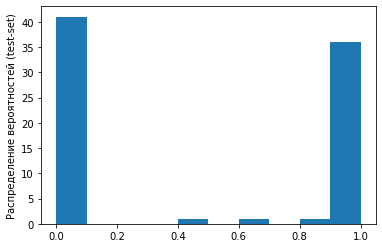

     features  importances
0  y__minimum     0.990347
2   y__median     0.007366
1     y__mean     0.002287

   Pos  Neg
0   40    0
1    2   38

AUC = 0.987  Точность = 0.975



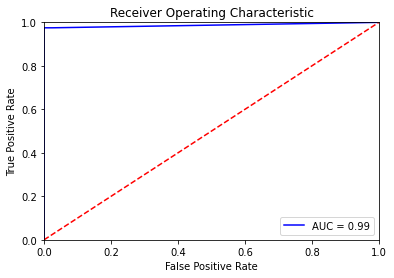

In [8]:
trainSet, testSet = train_test_split(features, test_size=0.4, random_state=42) 

## выводим статистику по нашим наборам
print('trainSet.shape =', trainSet.shape)
print('testSet.shape  =', testSet.shape)
print()
print('Value counts train:\n', trainSet.label.value_counts())
print()
print('Value counts test:\n', testSet.label.value_counts())

## лист фич
featureList = trainSet.drop(['index', 'label'], axis=1).columns

## параметры классификатора
params = {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 2, 'max_features' : 1.0, 'class_weight' : 'balanced', 'random_state': 42}

## обучаем классификатор
clf = RandomForestClassifier(**params).fit(trainSet[featureList], trainSet['label'])

## делаем предсказание на тестовом наборе
y_pred = clf.predict(testSet[featureList])
y_pred_proba = clf.predict_proba(testSet[featureList])[:, 1]  ## вероятности

## визуализируем вероятности для предсказаний
plt.hist(y_pred_proba)
plt.ylabel('Распределение вероятностей (test-set)')
plt.show()
## создадим для удобства дейтафрейм с результатами
res = testSet
res['pred'] = y_pred 
res['pred_proba'] = y_pred_proba

## получаем из классификатора важность фич и отображаем их
ftmprt = pd.DataFrame()
ftmprt['features'] = featureList
ftmprt['importances'] = clf.feature_importances_
ftmprt = ftmprt.sort_values('importances', ascending=False)
print(ftmprt.head(20))
print()
proba = res.pred_proba

## считаем матрицу ошибок
CM = confusion_matrix(res['label'], res['pred'])
CM_DF = pd.DataFrame(data=CM, columns = ['Pos', 'Neg'])
print(CM_DF)

# ROC-AUC 
FPR, TPR, thresholds = roc_curve(res['label'], res['pred_proba'])
roc_auc = auc(FPR, TPR)
acc = res[res['pred'] == res['label']].shape[0] / res.shape[0] ## точность
print(f"\nAUC = {roc_auc:.3f}  Точность = {acc:.3f}\n")

# ROC-кривая
plt.title('Receiver Operating Characteristic')
plt.plot(FPR, TPR, 'b', label=f'AUC = {roc_auc:.2f}')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

2 is correct answer
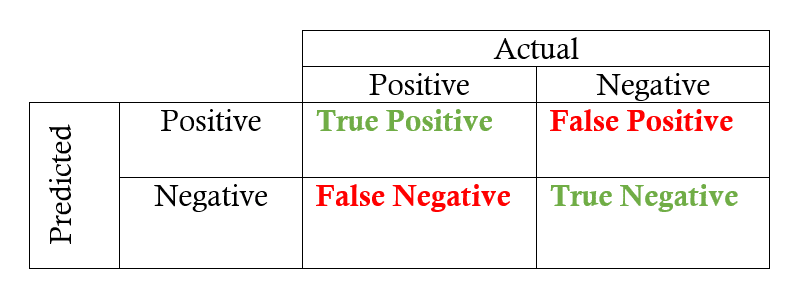

In [11]:
# ![изображение.png](attachment:28852663-9b62-4f86-83e9-10d8104838fa.png)

#### Задание 8.19.3
Посчитайте те же четыре фичи (max, min, mean, median), а также "count_below_mean" при помощи пакета TSFresh, результат запишите в датафрейм features. Укажите значение count_below_mean для ряда с id == 4. Ответ округлите до целого числа.

In [31]:
extraction_settings = \
    {
        "maximum": None,
        "minimum": None,
        "mean": None,
        "median": None,         
        "count_below_mean": None,
    }

#features = featuresTSFresh(data, extraction_settings) - wrong because:

#Прежде чем извлекать фичи, нужно удалить столбец с целевой переменной, 
#иначе из неё тоже извлекутся фичи, и мы подадим целевую переменную как признак в модель:
features = featuresTSFresh(data.drop(columns='label'), extraction_settings)
print(features)

## помечаем ряды (добавляем обратно первый и второй класс)
features['label'] = 0
features['label'].iloc[N:] = 1  

print('data.shape =', data.shape)                        
print('features.shape =', features.shape)
features.head(5)

display(np.round(features.loc[features.index[4]], 0))
#42 is correct



Feature Extraction:   0%|                                | 0/20 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████████████████| 20/20 [00:00<00:00, 386.16it/s]

     index  y__maximum  y__minimum   y__mean  y__median  y__count_below_mean
0        0    3.231294    1.957849  2.143130   1.957977                 47.0
1        1    3.634548    2.052910  2.972939   3.143508                 27.0
2        2    3.379718    1.957849  2.246776   1.958426                 45.0
3        3    3.463092    1.957850  2.339297   1.998222                 41.0
4        4    3.606816    1.957850  2.354036   1.986966                 42.0
..     ...         ...         ...       ...        ...                  ...
195    195    2.372536    0.714004  1.203662   1.008454                 39.0
196    196    1.003554    0.847096  0.922809   0.921486                 31.0
197    197    1.960760    0.828983  1.305666   1.257858                 33.0
198    198    3.298036    0.618728  2.110081   2.270264                 28.0
199    199    1.623059    1.548715  1.585773   1.585714                 31.0

[200 rows x 6 columns]
data.shape = (12200, 4)
features.shape = (200, 7)


/home/dex/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


index                   4.0
y__maximum              4.0
y__minimum              2.0
y__mean                 2.0
y__median               2.0
y__count_below_mean    42.0
label                   0.0
Name: 4, dtype: float64

In [7]:
#Если у кого-то при выполнении 8.19.3 будет зависать extract_features, примените костыль:
if __name__ == "__main__":
    features = extract_features(data,
                                  column_id='id',
                                  column_sort='t',
                                  default_fc_parameters=extraction_settings)

Feature Extraction: 100%|███████████████████████| 15/15 [00:00<00:00, 68.19it/s]
